In [1]:
from __future__ import print_function
import imageio, keras
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"
GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)
%matplotlib inline

In [2]:
from keras.datasets import cifar10

num_classes=10

img_rows, img_cols = 32, 32
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step
train_dataset shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
# Copy data to 3 channels and resample to get 56x56 images
# VGG needs atleast 48x48, so resample
# Center and resample diffraction array to desired pixel spacing
from scipy.ndimage.interpolation import zoom

def resample(diff3D, Nx, Ny): 
    nx, ny, nz = diff3D.shape
    diff3D=zoom(diff3D, (float(Nx)/nx,float(Ny)/ny, 1), order=1)
    return diff3D


from tqdm import tqdm
def copy3channels(input_data):
    dims = input_data.shape
    # dataset3 = np.zeros((dims[0],28,28,3),float)
    # for i in tqdm(range(dims[0])):
    #    dataset3[i,:,:,0], dataset3[i,:,:,1], dataset3[i,:,:,2] = input_data[i,:,:,0], input_data[i,:,:,0], input_data[i,:,:,0]
    data=[]
    for i in tqdm(range(dims[0])):
        tmp=resample(input_data[i,:,:,:],64,64)
        data.append(tmp)
    return np.array(data)

In [4]:
x_train_prepro = copy3channels(x_train)
x_test_prepro = copy3channels(x_test)

100%|██████████| 10000/10000 [00:09<00:00, 1022.87it/s]


In [5]:
x_train_prepro.shape

(50000, 64, 64, 3)

In [6]:
K.clear_session()

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical

import keras
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model, load_model
from keras.layers import GlobalMaxPooling2D
from keras.utils import np_utils
from keras import regularizers

weight_decay = 0.0005

#base_model.layers.pop() 
#Pop out the current logistic layer
base_model = VGG16(input_shape=(64, 64, 3), weights='imagenet', include_top=False)
for layers in base_model.layers:
    layers.trainable = False

tmp = Flatten()(base_model.output)
#Add a fully connected layer
tmp = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc1')(tmp)
tmp = BatchNormalization()(tmp)
tmp = Dropout(0.5)(tmp)
tmp = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(weight_decay), name='fc2')(tmp)
tmp = BatchNormalization()(tmp)
tmp = Dropout(0.5)(tmp)
predictions = Dense(10, activation='softmax')(tmp)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
    
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#Save model every epoch
# checkpoints=keras.callbacks.ModelCheckpoint('vgg_weights/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                # verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# print (model.summary())


# history=model.fit(x_train_prepro, y_train_onehot,
                #np_utils.to_categorical(labels,n_labels),  
                # batch_size=batch_size, epochs=epochs, verbose=1, validation_split = 0.25, callbacks=[checkpoints])

58892288/58889256 [==============================] - 7s 0us/step


In [7]:
## Callback for loss logging per epoch
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
batch_size=128
epochs=300

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16():
    
    history = LossHistory()
    model.fit(x_train_prepro, y_train_onehot, batch_size=batch_size, epochs=epochs,
              validation_split=0.15, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test_prepro, verbose=0)
    return predictions, history

def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [8]:
predictions, history = run_vgg16()
print(model.summary())

Train on 42500 samples, validate on 7500 samples
Epoch 1/300
42500/42500 [==============================] - 27s 626us/step - loss: 5.1490 - accuracy: 0.5000 - val_loss: 4.4756 - val_accuracy: 0.6320
Epoch 2/300
42500/42500 [==============================] - 23s 545us/step - loss: 4.7123 - accuracy: 0.5857 - val_loss: 4.3483 - val_accuracy: 0.6756
Epoch 3/300
42500/42500 [==============================] - 23s 549us/step - loss: 4.5409 - accuracy: 0.6165 - val_loss: 4.3185 - val_accuracy: 0.6723
Epoch 4/300
42500/42500 [==============================] - 23s 547us/step - loss: 4.4372 - accuracy: 0.6386 - val_loss: 4.2357 - val_accuracy: 0.6948
Epoch 5/300
42500/42500 [==============================] - 23s 547us/step - loss: 4.3710 - accuracy: 0.6482 - val_loss: 4.1965 - val_accuracy: 0.7008
Epoch 6/300
42500/42500 [==============================] - 23s 548us/step - loss: 4.3013 - accuracy: 0.6604 - val_loss: 4.1691 - val_accuracy: 0.7053
Epoch 7/300
42500/42500 [==========================

Epoch 55/300
42500/42500 [==============================] - 23s 543us/step - loss: 3.0038 - accuracy: 0.7952 - val_loss: 3.2345 - val_accuracy: 0.7483
Epoch 56/300
42500/42500 [==============================] - 23s 543us/step - loss: 2.9805 - accuracy: 0.8036 - val_loss: 3.2166 - val_accuracy: 0.7463
Epoch 57/300
42500/42500 [==============================] - 23s 543us/step - loss: 2.9619 - accuracy: 0.8032 - val_loss: 3.1983 - val_accuracy: 0.7511
Epoch 58/300
42500/42500 [==============================] - 23s 543us/step - loss: 2.9476 - accuracy: 0.8024 - val_loss: 3.1951 - val_accuracy: 0.7441
Epoch 59/300
42500/42500 [==============================] - 23s 545us/step - loss: 2.9475 - accuracy: 0.7978 - val_loss: 3.1763 - val_accuracy: 0.7461
Epoch 60/300
42500/42500 [==============================] - 23s 543us/step - loss: 2.9323 - accuracy: 0.8002 - val_loss: 3.1577 - val_accuracy: 0.7479
Epoch 61/300
42500/42500 [==============================] - 23s 545us/step - loss: 2.8917 - ac

42500/42500 [==============================] - 23s 543us/step - loss: 2.1752 - accuracy: 0.8588 - val_loss: 2.6804 - val_accuracy: 0.7428
Epoch 110/300
42500/42500 [==============================] - 23s 544us/step - loss: 2.1365 - accuracy: 0.8710 - val_loss: 2.7331 - val_accuracy: 0.7365
Epoch 111/300
42500/42500 [==============================] - 23s 545us/step - loss: 2.1537 - accuracy: 0.8615 - val_loss: 2.6805 - val_accuracy: 0.7421
Epoch 112/300
42500/42500 [==============================] - 23s 544us/step - loss: 2.1436 - accuracy: 0.8627 - val_loss: 2.6605 - val_accuracy: 0.7511
Epoch 113/300
42500/42500 [==============================] - 23s 544us/step - loss: 2.1320 - accuracy: 0.8614 - val_loss: 2.6580 - val_accuracy: 0.7444
Epoch 114/300
42500/42500 [==============================] - 23s 544us/step - loss: 2.0991 - accuracy: 0.8697 - val_loss: 2.6543 - val_accuracy: 0.7507
Epoch 115/300
42500/42500 [==============================] - 23s 544us/step - loss: 2.0775 - accuracy:

Epoch 163/300
42500/42500 [==============================] - 23s 546us/step - loss: 1.6432 - accuracy: 0.8953 - val_loss: 2.3730 - val_accuracy: 0.7503
Epoch 164/300
42500/42500 [==============================] - 23s 544us/step - loss: 1.6328 - accuracy: 0.8995 - val_loss: 2.3853 - val_accuracy: 0.7485
Epoch 165/300
42500/42500 [==============================] - 23s 543us/step - loss: 1.6082 - accuracy: 0.9055 - val_loss: 2.3804 - val_accuracy: 0.7435
Epoch 166/300
42500/42500 [==============================] - 23s 546us/step - loss: 1.6228 - accuracy: 0.8989 - val_loss: 2.3901 - val_accuracy: 0.7353
Epoch 167/300
42500/42500 [==============================] - 23s 543us/step - loss: 1.6451 - accuracy: 0.8899 - val_loss: 2.3675 - val_accuracy: 0.7409
Epoch 168/300
42500/42500 [==============================] - 23s 541us/step - loss: 1.6266 - accuracy: 0.8925 - val_loss: 2.3420 - val_accuracy: 0.7489
Epoch 169/300
42500/42500 [==============================] - 23s 543us/step - loss: 1.59

Epoch 217/300
42500/42500 [==============================] - 23s 543us/step - loss: 1.2814 - accuracy: 0.9209 - val_loss: 2.2253 - val_accuracy: 0.7363
Epoch 218/300
42500/42500 [==============================] - 23s 542us/step - loss: 1.2815 - accuracy: 0.9192 - val_loss: 2.1591 - val_accuracy: 0.7465
Epoch 219/300
42500/42500 [==============================] - 23s 545us/step - loss: 1.2806 - accuracy: 0.9204 - val_loss: 2.1716 - val_accuracy: 0.7433
Epoch 220/300
42500/42500 [==============================] - 23s 547us/step - loss: 1.2586 - accuracy: 0.9254 - val_loss: 2.1700 - val_accuracy: 0.7408
Epoch 221/300
42500/42500 [==============================] - 23s 546us/step - loss: 1.2297 - accuracy: 0.9329 - val_loss: 2.1683 - val_accuracy: 0.7443
Epoch 222/300
42500/42500 [==============================] - 23s 548us/step - loss: 1.2331 - accuracy: 0.9302 - val_loss: 2.1611 - val_accuracy: 0.7471
Epoch 223/300
42500/42500 [==============================] - 23s 547us/step - loss: 1.22

Epoch 271/300
42500/42500 [==============================] - 23s 542us/step - loss: 1.0925 - accuracy: 0.9206 - val_loss: 2.1044 - val_accuracy: 0.7291
Epoch 272/300
42500/42500 [==============================] - 23s 545us/step - loss: 1.1533 - accuracy: 0.9024 - val_loss: 1.9985 - val_accuracy: 0.7427
Epoch 273/300
42500/42500 [==============================] - 23s 544us/step - loss: 1.0753 - accuracy: 0.9255 - val_loss: 2.0684 - val_accuracy: 0.7304
Epoch 274/300
42500/42500 [==============================] - 23s 544us/step - loss: 1.1357 - accuracy: 0.9074 - val_loss: 1.9708 - val_accuracy: 0.7420
Epoch 275/300
42500/42500 [==============================] - 23s 544us/step - loss: 1.1002 - accuracy: 0.9155 - val_loss: 2.0132 - val_accuracy: 0.7349
Epoch 276/300
42500/42500 [==============================] - 23s 544us/step - loss: 1.1359 - accuracy: 0.9057 - val_loss: 2.0620 - val_accuracy: 0.7261
Epoch 277/300
42500/42500 [==============================] - 23s 545us/step - loss: 1.13

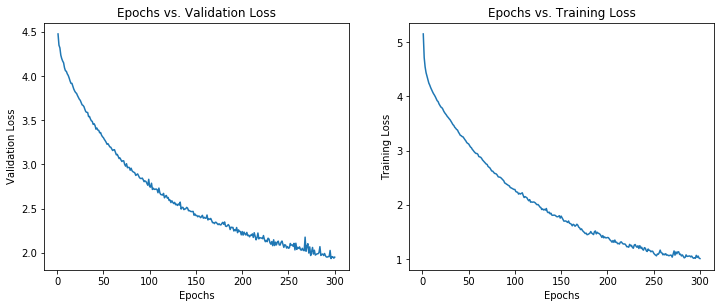

In [9]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,301), history.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,301), history.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

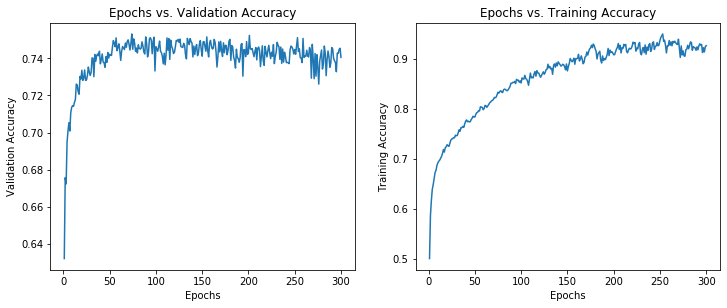

In [10]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,301), history.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,301), history.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [11]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 72.89 %


In [14]:
epochs=100
predictions1, history1 = run_vgg16()
print(model.summary())

Train on 42500 samples, validate on 7500 samples
Epoch 1/100
42500/42500 [==============================] - 22s 525us/step - loss: 1.0422 - accuracy: 0.9175 - val_loss: 1.9299 - val_accuracy: 0.7456
Epoch 2/100
42500/42500 [==============================] - 22s 527us/step - loss: 0.9961 - accuracy: 0.9319 - val_loss: 1.9388 - val_accuracy: 0.7331
Epoch 3/100
42500/42500 [==============================] - 22s 527us/step - loss: 0.9917 - accuracy: 0.9316 - val_loss: 1.9689 - val_accuracy: 0.7427
Epoch 4/100
42500/42500 [==============================] - 22s 525us/step - loss: 1.0193 - accuracy: 0.9226 - val_loss: 1.9071 - val_accuracy: 0.7456
Epoch 5/100
42500/42500 [==============================] - 22s 527us/step - loss: 0.9931 - accuracy: 0.9294 - val_loss: 1.9261 - val_accuracy: 0.7401
Epoch 6/100
42500/42500 [==============================] - 22s 525us/step - loss: 1.0018 - accuracy: 0.9263 - val_loss: 1.9445 - val_accuracy: 0.7476
Epoch 7/100
42500/42500 [==========================

Epoch 55/100
42500/42500 [==============================] - 22s 527us/step - loss: 0.9609 - accuracy: 0.9132 - val_loss: 1.8583 - val_accuracy: 0.7388
Epoch 56/100
42500/42500 [==============================] - 22s 524us/step - loss: 0.9557 - accuracy: 0.9143 - val_loss: 1.8350 - val_accuracy: 0.7377
Epoch 57/100
42500/42500 [==============================] - 22s 526us/step - loss: 0.9302 - accuracy: 0.9224 - val_loss: 1.8326 - val_accuracy: 0.7392
Epoch 58/100
42500/42500 [==============================] - 22s 527us/step - loss: 0.9385 - accuracy: 0.9204 - val_loss: 1.8315 - val_accuracy: 0.7427
Epoch 59/100
42500/42500 [==============================] - 22s 527us/step - loss: 0.9124 - accuracy: 0.9268 - val_loss: 1.8192 - val_accuracy: 0.7452
Epoch 60/100
42500/42500 [==============================] - 22s 526us/step - loss: 0.8817 - accuracy: 0.9370 - val_loss: 1.8525 - val_accuracy: 0.7433
Epoch 61/100
42500/42500 [==============================] - 22s 525us/step - loss: 0.8606 - ac

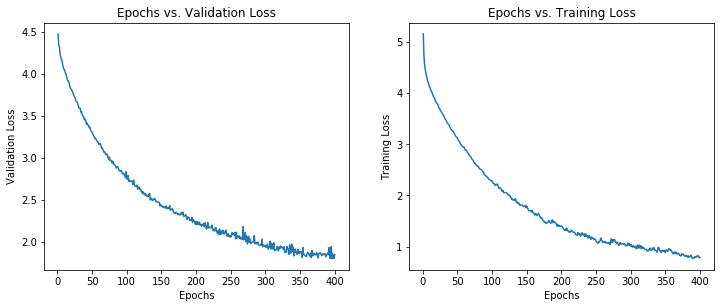

In [15]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,401), history.val_losses+history1.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,401), history.losses+history1.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

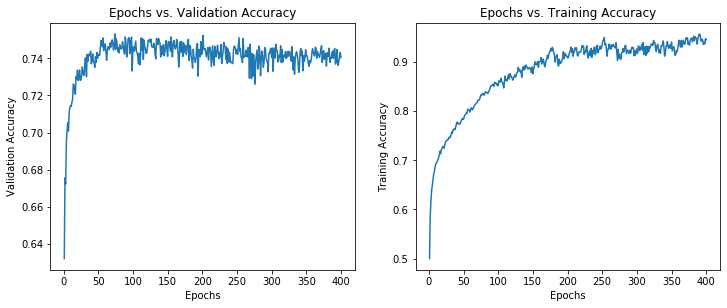

In [16]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,401), history.val_accuracy+history1.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,401), history.accuracy+history1.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [17]:
def test_accuracy1():
    err = []
    t = 0
    for i in range(predictions1.shape[0]):
        if (np.argmax(predictions1[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions1.shape[0], err
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 72.89 %


In [18]:
import h5py
model.save_weights('cifar-trans-norm-lr-3-batch128_weights.h5')
vggmodel_json = model.to_json()
with open ("cifar-trans-norm-lr-3-batch128.json", "w") as json_file:
    json_file.write(vggmodel_json)

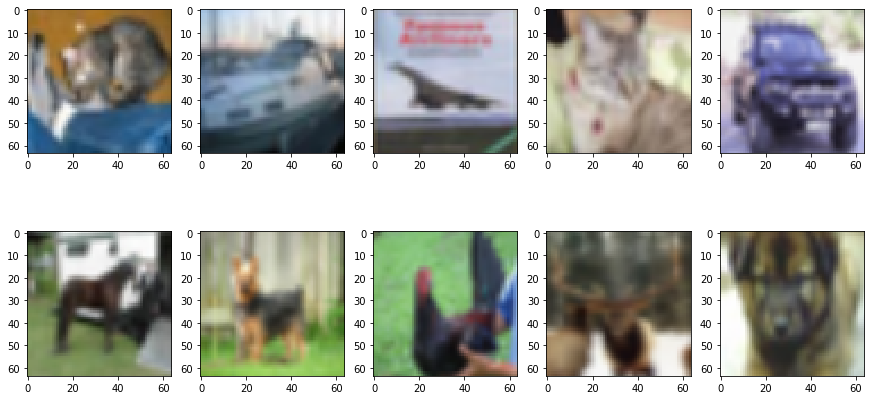

True:          [[3]
 [8]
 [0]
 [3]
 [1]]
classified as: [5 1 8 4 6]
True:          [[7]
 [5]
 [2]
 [4]
 [5]]
classified as: [5 4 5 3 3]


In [19]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test_prepro[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test_prepro[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))

In [30]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='wrap')  

In [24]:
## Callback for loss logging per epoch
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
batch_size=128

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))

early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='auto')

def run_vgg16_aug():
    
    history = LossHistory()
    datagen.fit(x_train_prepro)
    model.fit_generator(datagen.flow(x_train_prepro[:42500,:,:,:], y_train_onehot[:42500,:], batch_size=batch_size),
                        steps_per_epoch=x_train_prepro.shape[0] // batch_size,
                        epochs=epochs, validation_data=(x_train_prepro[42501:,:,:,:], y_train_onehot[42501:,:]), 
                        verbose=1, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(x_test_prepro, verbose=0)
    return predictions, history

In [26]:
epochs=100
predictions_aug, history_aug = run_vgg16_aug()

Epoch 1/100
390/390 [==============================] - 64s 163ms/step - loss: 1.5984 - accuracy: 0.7470 - val_loss: 1.6939 - val_accuracy: 0.7349
Epoch 2/100
390/390 [==============================] - 73s 187ms/step - loss: 1.5284 - accuracy: 0.7398 - val_loss: 1.5848 - val_accuracy: 0.7298
Epoch 3/100
390/390 [==============================] - 67s 173ms/step - loss: 1.4392 - accuracy: 0.7574 - val_loss: 1.5701 - val_accuracy: 0.7436
Epoch 4/100
390/390 [==============================] - 69s 176ms/step - loss: 1.4178 - accuracy: 0.7553 - val_loss: 1.4974 - val_accuracy: 0.7448
Epoch 5/100
390/390 [==============================] - 73s 188ms/step - loss: 1.3907 - accuracy: 0.7588 - val_loss: 1.4782 - val_accuracy: 0.7481
Epoch 6/100
390/390 [==============================] - 65s 167ms/step - loss: 1.3806 - accuracy: 0.7619 - val_loss: 1.4724 - val_accuracy: 0.7542
Epoch 7/100
390/390 [==============================] - 72s 184ms/step - loss: 1.3608 - accuracy: 0.7624 - val_loss: 1.4555 -

Epoch 57/100
390/390 [==============================] - 73s 186ms/step - loss: 1.0559 - accuracy: 0.8161 - val_loss: 1.2738 - val_accuracy: 0.7653
Epoch 58/100
390/390 [==============================] - 73s 188ms/step - loss: 1.0444 - accuracy: 0.8164 - val_loss: 1.2554 - val_accuracy: 0.7674
Epoch 59/100
390/390 [==============================] - 73s 186ms/step - loss: 1.0384 - accuracy: 0.8195 - val_loss: 1.2492 - val_accuracy: 0.7673
Epoch 60/100
390/390 [==============================] - 73s 186ms/step - loss: 1.0234 - accuracy: 0.8232 - val_loss: 1.2617 - val_accuracy: 0.7654
Epoch 61/100
390/390 [==============================] - 73s 186ms/step - loss: 1.0369 - accuracy: 0.8214 - val_loss: 1.2524 - val_accuracy: 0.7669
Epoch 62/100
390/390 [==============================] - 73s 187ms/step - loss: 1.0308 - accuracy: 0.8216 - val_loss: 1.2683 - val_accuracy: 0.7641
Epoch 63/100
390/390 [==============================] - 73s 187ms/step - loss: 1.0299 - accuracy: 0.8194 - val_loss: 1

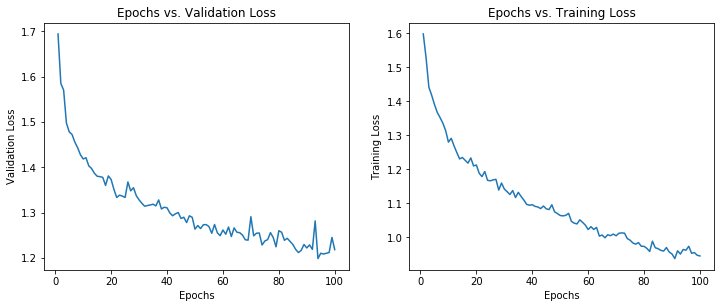

In [27]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,101), history_aug.val_losses)
ax1.set(xlabel='Epochs', ylabel='Validation Loss',
       title='Epochs vs. Validation Loss')
ax2.plot(np.arange(1,101), history_aug.losses)
ax2.set(xlabel='Epochs', ylabel='Training Loss',
       title='Epochs vs. Training Loss')
plt.show()

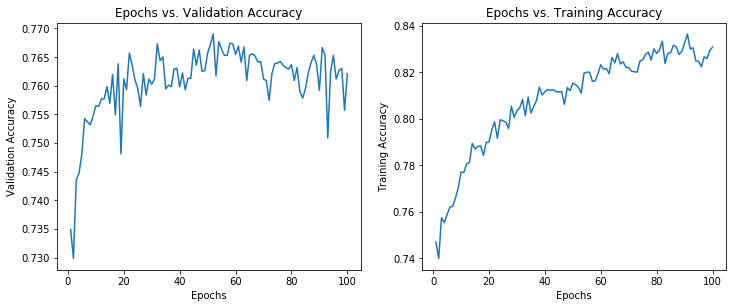

In [29]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)

ax1.plot(np.arange(1,101), history_aug.val_accuracy)
ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
       title='Epochs vs. Validation Accuracy')
ax2.plot(np.arange(1,101), history_aug.accuracy)
ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
       title='Epochs vs. Training Accuracy')
plt.show()

In [33]:
def test_accuracy_aug():
    err = []
    t = 0
    for i in range(predictions_aug.shape[0]):
        if (np.argmax(predictions_aug[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions_aug.shape[0], err
p = test_accuracy_aug()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 75.25 %
